In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")




4. Build a predictive model to predict the MPG based on other data. What is your optimal error metric on the test set?

In [2]:
# Reading the data
cars = pd.read_csv('cars.csv', sep=';')

In [3]:
print("Sample of the data")
print(cars.head())

Sample of the data
                         Car     MPG Cylinders Displacement Horsepower  \
0                     STRING  DOUBLE       INT       DOUBLE     DOUBLE   
1  Chevrolet Chevelle Malibu    18.0         8        307.0      130.0   
2          Buick Skylark 320    15.0         8        350.0      165.0   
3         Plymouth Satellite    18.0         8        318.0      150.0   
4              AMC Rebel SST    16.0         8        304.0      150.0   

   Weight Acceleration Model Origin  
0  DOUBLE       DOUBLE   INT    CAT  
1   3504.         12.0    70     US  
2   3693.         11.5    70     US  
3   3436.         11.0    70     US  
4   3433.         12.0    70     US  


In [4]:
# Dropping the first row with data_type information
print(f"First row with data_type {cars.iloc[0]}")
cars.drop(0, axis = 0, inplace = True)

First row with data_type Car             STRING
MPG             DOUBLE
Cylinders          INT
Displacement    DOUBLE
Horsepower      DOUBLE
Weight          DOUBLE
Acceleration    DOUBLE
Model              INT
Origin             CAT
Name: 0, dtype: object


In [5]:
# Converting the data columns to their actual data_type
cars['Car'] = cars['Car'].astype(str)
cars['MPG'] = cars['MPG'].astype(float)
cars['Cylinders'] = cars['Cylinders'].astype(int)
cars['Displacement'] = cars['Displacement'].astype(float)
cars['Horsepower'] = cars['Horsepower'].astype(float)
cars['Weight'] = cars['Weight'].astype(float)
cars['Acceleration'] = cars['Acceleration'].astype(float)
cars['Model'] = cars['Model'].astype(int)
cars['Origin'] = cars['Origin'].astype("category")

In [6]:
# Removing the rows where the data is incomplete
cars.drop(cars[cars.MPG == 0.0].index, axis=0, inplace=True)
cars.drop(cars[cars.Horsepower == 0.0].index, axis=0, inplace=True)
print(cars.describe())

              MPG   Cylinders  Displacement  Horsepower       Weight  \
count  392.000000  392.000000    392.000000  392.000000   392.000000   
mean    23.445918    5.471939    194.411990  104.469388  2977.584184   
std      7.805007    1.705783    104.644004   38.491160   849.402560   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.000000    4.000000    105.000000   75.000000  2225.250000   
50%     22.750000    4.000000    151.000000   93.500000  2803.500000   
75%     29.000000    8.000000    275.750000  126.000000  3614.750000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       Acceleration       Model  
count    392.000000  392.000000  
mean      15.541327   75.979592  
std        2.758864    3.683737  
min        8.000000   70.000000  
25%       13.775000   73.000000  
50%       15.500000   76.000000  
75%       17.025000   79.000000  
max       24.800000   82.000000  


## 1. Find the car with the highest MPG

In [7]:
print(f"Car with highest MPG: {cars[cars.MPG == cars.MPG.max()]}")

Car with highest MPG:            Car   MPG  Cylinders  Displacement  Horsepower  Weight  \
330  Mazda GLC  46.6          4          86.0        65.0  2110.0   

     Acceleration  Model Origin  
330          17.9     80  Japan  


## 2. Find the average MPG per Cylinder count

In [8]:
print(f"Average MPG per Cylinder count: {cars.groupby('Cylinders').MPG.mean()}")

Average MPG per Cylinder count: Cylinders
3    20.550000
4    29.283920
5    27.366667
6    19.973494
8    14.963107
Name: MPG, dtype: float64


### 3. Find each make's average MPG (Cherry, Ford, etc)

In [9]:
# Extracting Make of the Car from the Car name
cars['Make'] = cars.Car.str.split(' ').str[0]

In [10]:
# Replacing misspelled Make
misspelled = {'Chevrolete': 'Chevrolet',
              'Hi': 'Harvester',
              'Mercedes-Benz': 'Mercedes',
              }
cars['Make'] = cars['Make'].replace(misspelled)

In [11]:
print(f"Average MPG by Make: {cars.groupby('Make').MPG.mean()}")

Average MPG by Make: Make
AMC           18.070370
Audi          26.714286
BMW           23.750000
Buick         19.182353
Cadillac      19.750000
Capri         25.000000
Chevrolet     20.206667
Chevy         20.500000
Chrysler      17.266667
Datsun        31.113043
Dodge         22.060714
Fiat          28.912500
Ford          19.475000
Harvester      9.000000
Honda         33.761538
Mazda         30.058333
Mercedes      23.966667
Mercury       19.118182
Nissan        36.000000
Oldsmobile    21.100000
Opel          25.750000
Peugeot       23.687500
Plymouth      21.703226
Pontiac       20.012500
Renault       29.666667
Saab          23.900000
Subaru        30.525000
Toyota        28.165385
Triumph       35.000000
Volkswagen    31.840909
Volvo         21.116667
Name: MPG, dtype: float64


### 4. Build a predictive model to predict the MPG based on other data. What is your optimal error metric on the test set?

In [12]:
cars.head()

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin,Make
1,Chevrolet Chevelle Malibu,18.0,8,307.0,130.0,3504.0,12.0,70,US,Chevrolet
2,Buick Skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,US,Buick
3,Plymouth Satellite,18.0,8,318.0,150.0,3436.0,11.0,70,US,Plymouth
4,AMC Rebel SST,16.0,8,304.0,150.0,3433.0,12.0,70,US,AMC
5,Ford Torino,17.0,8,302.0,140.0,3449.0,10.5,70,US,Ford


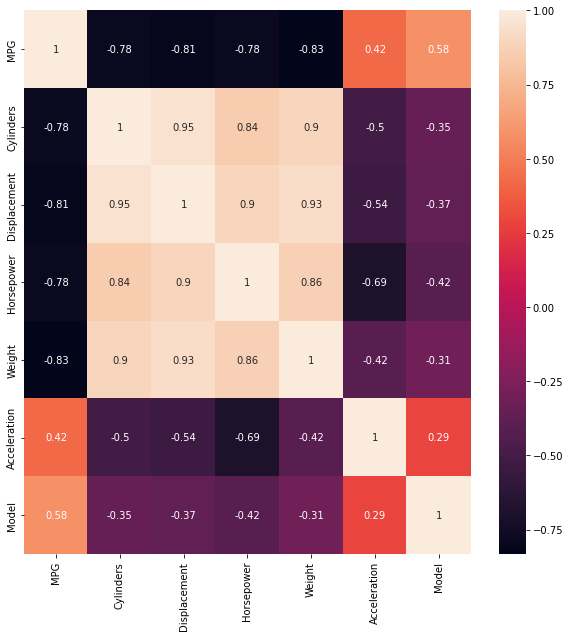

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(cars.corr(), annot=True)

In [14]:
cars.head()

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin,Make
1,Chevrolet Chevelle Malibu,18.0,8,307.0,130.0,3504.0,12.0,70,US,Chevrolet
2,Buick Skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,US,Buick
3,Plymouth Satellite,18.0,8,318.0,150.0,3436.0,11.0,70,US,Plymouth
4,AMC Rebel SST,16.0,8,304.0,150.0,3433.0,12.0,70,US,AMC
5,Ford Torino,17.0,8,302.0,140.0,3449.0,10.5,70,US,Ford


#### Target (MPG)

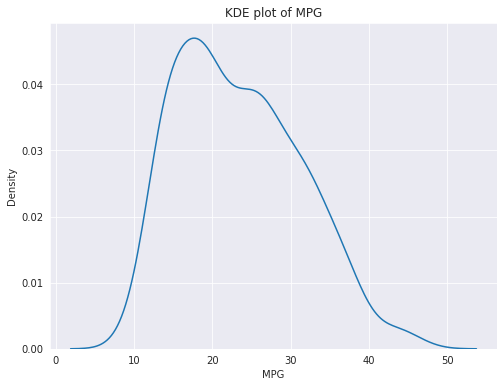

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.kdeplot(cars.MPG)
plt.title("KDE plot of MPG")
plt.show()

In [16]:
cars['MPG'] = np.log1p(cars.MPG)

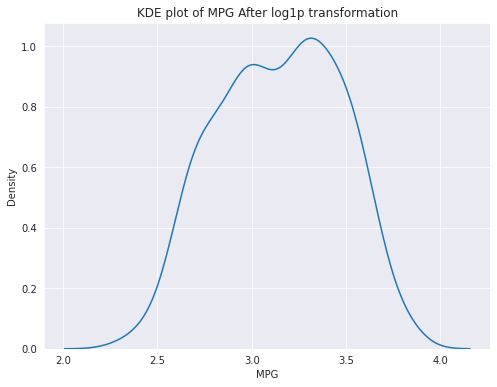

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.kdeplot(cars.MPG)
plt.title("KDE plot of MPG After log1p transformation")
plt.show()

### One Hot Encoding the feature columns

In [18]:
cars = pd.get_dummies(cars, columns=['Cylinders','Origin','Make'], drop_first=True)

#### Train test split

In [19]:
X = cars.drop(['MPG', 'Car'], axis = 1)
y = cars['MPG']
X_train, X_test, y_train, y_test = train_test_split(X , y,test_size  = 0.2, random_state = 116)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}\ny_test Shape: {y_test.shape}')

X_train Shape: (313, 41)
X_test Shape: (79, 41)
y_train Shape: (313,)
y_test Shape: (79,)


In [20]:
ss_train = StandardScaler()
ss_test = StandardScaler()

In [21]:
X_train = ss_train.fit_transform(X_train)
X_test = ss_test.fit_transform(X_test)

### Predictive Models

#### XGBRegressor

In [22]:
# Using grid search to find the optimal hyper parameters
param_dict = {'n_estimators':[100,300,500,800], 'max_depth':[2,4,6,8]}
gs = GridSearchCV(XGBRegressor(), param_grid=param_dict, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=6, refit=True)
gs.fit(X_train, y_train)
xgb = gs.best_estimator_
print(f"Best parameters are {gs.best_params_}")
print(f"Best score is {gs.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[03:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters are {'max_depth': 4, 'n_estimators': 100}
Best score is -0.011596114380163728


In [23]:
xgb_predict_train = xgb.predict(X_train)
xgb_predict_test = xgb.predict(X_test)
print(f"RMSE for train is {np.sqrt(mean_squared_error(y_train, xgb_predict_train))}")
print(f"RMSE for test is {np.sqrt(mean_squared_error(y_test, xgb_predict_test))}")
print(f"R2 score for train is {r2_score(y_train, xgb_predict_train)}")
print(f"R2 score for test is {r2_score(y_test, xgb_predict_test)}")

RMSE for train is 0.047263764672025727
RMSE for test is 0.10003268892242662
R2 score for train is 0.9790792342822849
R2 score for test is 0.8971481122614369


#### AdaBoostRegressor

In [24]:
# Using grid search to find the optimal hyper parameters
param_dict = {'n_estimators':[100,300,500,800], 'learning_rate':[1, 10, 100]}
gs = GridSearchCV(AdaBoostRegressor(), param_grid=param_dict, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=6, refit=True)
gs.fit(X_train, y_train)
adb = gs.best_estimator_
print(f"Best parameters are {gs.best_params_}")
print(f"Best score is {gs.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters are {'learning_rate': 1, 'n_estimators': 800}
Best score is -0.012746878340731262


In [25]:
adb_predict_train = adb.predict(X_train)
adb_predict_test = adb.predict(X_test)
print(f"RMSE for train is {np.sqrt(mean_squared_error(y_train, adb_predict_train))}")
print(f"RMSE for test is {np.sqrt(mean_squared_error(y_test, adb_predict_test))}")
print(f"R2 score for train is {r2_score(y_train, adb_predict_train)}")
print(f"R2 score for test is {r2_score(y_test, adb_predict_test)}")

RMSE for train is 0.09246051752806912
RMSE for test is 0.12735286133610346
R2 score for train is 0.9199366803055382
R2 score for test is 0.8332960865403695


#### RandomForestRegressor

In [26]:
# Using grid search to find the optimal hyper parameters
param_dict = {'n_estimators':[100,300,500,800], 'max_depth':[2,4,6,8]}
gs = GridSearchCV(RandomForestRegressor(), param_grid=param_dict, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=6, refit=True)
gs.fit(X_train, y_train)
rf = gs.best_estimator_
print(f"Best parameters are {gs.best_params_}")
print(f"Best score is {gs.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters are {'max_depth': 6, 'n_estimators': 300}
Best score is -0.01182987003574544


In [27]:
rf_predict_train = rf.predict(X_train)
rf_predict_test = rf.predict(X_test)
print(f"RMSE for train is {np.sqrt(mean_squared_error(y_train, rf_predict_train))}")
print(f"RMSE for test is {np.sqrt(mean_squared_error(y_test, rf_predict_test))}")
print(f"R2 score for train is {r2_score(y_train, rf_predict_train)}")
print(f"R2 score for test is {r2_score(y_test, rf_predict_test)}")

RMSE for train is 0.059525841177516366
RMSE for test is 0.10537577446475352
R2 score for train is 0.9668157477489
R2 score for test is 0.8858673397282992


In [28]:
print(
"""
XGBRegressor model has the best performance on the test set.

Root Mean Square Error for test set: 0.10003268892242662 (lower is better)

R2 score for the test set: 0.8971481122614369 (higher is better)
"""
)


XGBRegressor model has the best performance on the test set.

Root Mean Square Error for test set: 0.10003268892242662 (lower is better)

R2 score for the test set: 0.8971481122614369 (higher is better)



XGBRegressor model has the best performance on the test set.

Root Mean Square Error for test set: 0.10003268892242662 (lower is better)

R2 score for the test set: 0.8971481122614369 (higher is better)

In [29]:
!pip freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.2.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cachetools==5.2.1
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
cftime==1.6.2
chardet==4.0.0
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==2.2.0
cmake==3.22.6
cmdstanpy==1.0.8
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.3
cycler==0.11.0
cymem==2.0.7
Cython==0.29.33
daft==0.0.4
dask==2022.2.1
datascience==0.17.5
db-dtypes==1.0.5
dbus-python==1.2.16
debugpy==1.0.0
decorator==4.4.2
de